# Train a CNTK model

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import glob
import os
import numpy as np
from PIL import Image
from shutil import copyfile
import sys
import tarfile
import time

# Loat the right urlretrieve based on python version
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

import zipfile

# Useful for being able to dump images into the Notebook
import IPython.display as D

# Import CNTK and helpers
import cntk as C

## Settings

In [3]:
isFast = True


In [4]:
C.device.try_set_default_device(C.device.gpu(0))

True

In [5]:
data_root = "/data"
output_path = "/data/out"

In [6]:
base_model_file="/data/VGG16_ImageNet_Caffe.model"

In [39]:
subset = glob.glob("/data/drinks/valid/*/img*4.jpg")

## Utility functions

In [7]:
import cntk.io.transforms as xforms


def ensure_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
# Creates a minibatch source for training or testing
def create_mb_source(map_file, image_dims, num_classes, randomize=True):
    transforms = [xforms.scale(width=image_dims[2], height=image_dims[1], channels=image_dims[0], interpolations='linear')]
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
            features=C.io.StreamDef(field='image', transforms=transforms),
            labels=C.io.StreamDef(field='label', shape=num_classes))),
            randomize=randomize)

# Creates the network model for transfer learning
def create_model(model_details, num_classes, input_features, new_prediction_node_name='prediction', freeze=False):
    # Load the pretrained classification net and find nodes
    base_model = C.load_model(model_details['model_file'])
    feature_node = C.logging.find_by_name(base_model, model_details['feature_node_name'])
    last_node = C.logging.find_by_name(base_model, model_details['last_hidden_node_name'])
    # Clone the desired layers with fixed weights
    cloned_layers = C.combine([last_node.owner]).clone(
        C.CloneMethod.freeze if freeze else C.CloneMethod.clone,
        {feature_node: C.placeholder(name='features')})

    # Add new dense layer for class prediction
    cloned_out = cloned_layers(input_features)
    z = C.layers.Dense(num_classes, activation=None, name=new_prediction_node_name) (cloned_out)

    return z

In [8]:
# Trains a transfer learning model
#def create_model(model_details, num_classes, input_features, new_prediction_node_name='prediction', freeze=False):
def train_model(model_details, num_classes, train_map_file,
                learning_params, max_images=-1):
    num_epochs = learning_params['max_epochs']
    epoch_size = sum(1 for line in open(train_map_file))
    if max_images > 0:
        epoch_size = min(epoch_size, max_images)
    minibatch_size = learning_params['mb_size']

    # Create the minibatch source and input variables
    minibatch_source = create_mb_source(train_map_file, model_details['image_dims'], num_classes)
    image_input = C.input_variable(model_details['image_dims'])
    label_input = C.input_variable(num_classes)

    # Define mapping from reader streams to network inputs
    input_map = {
        image_input: minibatch_source['features'],
        label_input: minibatch_source['labels']
    }

    # Instantiate the transfer learning model and loss function
    tl_model = create_model(model_details, num_classes, image_input, freeze=learning_params['freeze_weights'])
    ce = C.cross_entropy_with_softmax(tl_model, label_input)
    pe = C.classification_error(tl_model, label_input)

    # Instantiate the trainer object
    lr_schedule = C.learning_rate_schedule(learning_params['lr_per_mb'], unit=C.UnitType.minibatch)
    mm_schedule = C.momentum_schedule(learning_params['momentum_per_mb'])
    learner = C.momentum_sgd(tl_model.parameters, lr_schedule, mm_schedule,
                           l2_regularization_weight=learning_params['l2_reg_weight'])
    trainer = C.Trainer(tl_model, (ce, pe), learner)

    # Get minibatches of images and perform model training
    print("Training transfer learning model for {0} epochs (epoch_size = {1}).".format(num_epochs, epoch_size))
    C.logging.log_number_of_parameters(tl_model)
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=num_epochs)
    for epoch in range(num_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = minibatch_source.next_minibatch(min(minibatch_size, epoch_size - sample_count), input_map=input_map)
            trainer.train_minibatch(data)                                    # update model with it
            sample_count += trainer.previous_minibatch_sample_count          # count samples processed so far
            progress_printer.update_with_trainer(trainer, with_metric=True)  # log progress
            if sample_count % (100 * minibatch_size) == 0:
                print ("Processed {0} samples".format(sample_count))

        progress_printer.epoch_summary(with_metric=True)

    return tl_model

In [9]:
# Evaluates a single image using the re-trained model
def eval_single_image(loaded_model, image_path, image_dims):
    # load and format image (resize, RGB -> BGR, CHW -> HWC)
    try:
        img = Image.open(image_path)

        if image_path.endswith("png"):
            temp = Image.new("RGB", img.size, (255, 255, 255))
            temp.paste(img, img)
            img = temp
        resized = img.resize((image_dims[2], image_dims[1]), Image.ANTIALIAS)
        bgr_image = np.asarray(resized, dtype=np.float32)[..., [2, 1, 0]]
        hwc_format = np.ascontiguousarray(np.rollaxis(bgr_image, 2))

        # compute model output
        arguments = {loaded_model.arguments[0]: [hwc_format]}
        output = loaded_model.eval(arguments)

        # return softmax probabilities
        sm = C.softmax(output[0])
        return sm.eval()
    except FileNotFoundError:
        print("Could not open (skipping file): ", image_path)
        return ['None']



# Evaluates an image set using the provided model
def eval_test_images(loaded_model, output_file, test_map_file, image_dims, max_images=-1, column_offset=0):
    num_images = sum(1 for line in open(test_map_file))
    if max_images > 0:
        num_images = min(num_images, max_images)
    if isFast:
        num_images = min(num_images, 300) #We will run through fewer images for test run

    print("Evaluating model output node '{0}' for {1} images.".format('prediction', num_images))

    pred_count = 0
    correct_count = 0
    np.seterr(over='raise')
    with open(output_file, 'wb') as results_file:
        with open(test_map_file, "r") as input_file:
            for line in input_file:
                tokens = line.rstrip().split('\t')
                img_file = tokens[0 + column_offset]
                probs = eval_single_image(loaded_model, img_file, image_dims)

                if probs[0]=='None':
                    print("Eval not possible: ", img_file)
                    continue

                pred_count += 1
                true_label = int(tokens[1 + column_offset])
                predicted_label = np.argmax(probs)
                if predicted_label == true_label:
                    correct_count += 1
                else:
                    print("Wrong prediction for: {0}: real {1}, predicted {2}".format(img_file, true_label, predicted_label))

                np.savetxt(results_file, probs[np.newaxis], fmt="%.3f")
                if pred_count % 100 == 0:
                    print("Processed {0} samples ({1:.2%} correct)".format(pred_count,
                                                                           (float(correct_count) / pred_count)))
                if pred_count >= num_images:
                    break
    print ("{0} of {1} prediction were correct".format(correct_count, pred_count))
    return correct_count, pred_count, (float(correct_count) / pred_count)


In [10]:
def create_map_file_from_folder(root_folder, class_mapping, include_unknown=False, valid_extensions=['.jpg', '.jpeg', '.png']):
    map_file_name = os.path.join(root_folder, "map.txt")

    map_file = open(map_file_name , 'w', encoding='utf-8')

    for class_id in range(0, len(class_mapping)):
        folder = os.path.join(root_folder, class_mapping[class_id])
        if os.path.exists(folder):
            for entry in os.listdir(folder):
                filename = os.path.abspath(os.path.join(folder, entry))
                if os.path.isfile(filename) and os.path.splitext(filename)[1].lower() in valid_extensions:
                    try:
                        map_file.write("{0}\t{1}\n".format(filename, class_id))
                    except UnicodeEncodeError:
                        continue

    if include_unknown:
        for entry in os.listdir(root_folder):
            filename = os.path.abspath(os.path.join(root_folder, entry))
            if os.path.isfile(filename) and os.path.splitext(filename)[1].lower() in valid_extensions:
                try:
                    map_file.write("{0}\t-1\n".format(filename))
                except UnicodeEncodeError:
                    continue

    map_file.close()

    return map_file_name


def create_class_mapping_from_folder(root_folder):
    classes = []
    for _, directories, _ in os.walk(root_folder):
        for directory in directories:
            classes.append(directory)
    return np.asarray(classes)

In [11]:
from cntk.logging.graph import *
from cntk.layers.typing import *
def get_model_layers(root):
    """Returns a list of the high-level layers (.e. function blocks) that make up the CNTK model """
    stack = [root.root_function]  # node
    layers = []         # final result, list of all relevant layers
    visited = set()

    while stack:
        node = stack.pop(0)
        from cntk import cntk_py
        try:
            # Function node
            stack = list(node.root_function.inputs) + stack
        except AttributeError:
            # OutputVariable node. We need process the owner node if this is an output.
            try:
                if node.is_output:
                    stack.insert(0, node.owner)
                    continue
            except AttributeError:
                pass
        # Add function nodes but skip Variable nodes
        if not isinstance(node, Variable):
            layers.append(node)

    layers.reverse()

    return layers

In [12]:
import matplotlib.pyplot as plt
import cv2

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


## Import base model

In [14]:
%%bash -s "$base_model_file"
test -e $1 || curl -L -S -O $1 https://www.cntk.ai/Models/Caffe_Converted/VGG16_ImageNet_Caffe.model

In [16]:
# Print out all layers in the model
print('Loading {} and printing all layers:'.format(base_model_file))
node_outputs = C.logging.get_node_outputs(C.load_model(base_model_file))
for l in node_outputs: print("  {0} {1}".format(l.name, l.shape))

Loading /data/VGG16_ImageNet_Caffe.model and printing all layers:
  prob (1000,)
  prob (1000,)
  fc8 (1000,)
  drop7 (4096,)
  relu7 (4096,)
  fc7 (4096,)
  drop6 (4096,)
  relu6 (4096,)
  fc6 (4096,)
  pool5 (512, 7, 7)
  relu5_3 (512, 14, 14)
  conv5_3 (512, 14, 14)
  relu5_2 (512, 14, 14)
  conv5_2 (512, 14, 14)
  relu5_1 (512, 14, 14)
  conv5_1 (512, 14, 14)
  pool4 (512, 14, 14)
  relu4_3 (512, 28, 28)
  conv4_3 (512, 28, 28)
  relu4_2 (512, 28, 28)
  conv4_2 (512, 28, 28)
  relu4_1 (512, 28, 28)
  conv4_1 (512, 28, 28)
  pool3 (256, 28, 28)
  relu3_3 (256, 56, 56)
  conv3_3 (256, 56, 56)
  relu3_2 (256, 56, 56)
  conv3_2 (256, 56, 56)
  relu3_1 (256, 56, 56)
  conv3_1 (256, 56, 56)
  pool2 (128, 56, 56)
  relu2_2 (128, 112, 112)
  conv2_2 (128, 112, 112)
  relu2_1 (128, 112, 112)
  conv2_1 (128, 112, 112)
  pool1 (64, 112, 112)
  relu1_2 (64, 224, 224)
  conv1_2 (64, 224, 224)
  relu1_1 (64, 224, 224)
  conv1_1 (64, 224, 224)


In [17]:
# define base model location and characteristics
base_model = {
    'model_file': base_model_file,
    'feature_node_name': 'data',
    'last_hidden_node_name': 'drop7',
    # Channel Depth x Height x Width
    'image_dims': (3, 224, 224)
}

In [18]:
force_retraining = True

max_training_epochs = 5 if isFast else 20

learning_params = {
    'max_epochs': max_training_epochs,
    'mb_size': 50,
    'lr_per_mb': [0.2]*10 + [0.1],
    'momentum_per_mb': 0.9,
    'l2_reg_weight': 0.0005,
    'freeze_weights': True
}


In [19]:
drinks_data = {
        'training_folder': '/data/drinks/train',
        'testing_folder': '/data/drinks/valid'
    }

drinks_data['class_mapping'] = create_class_mapping_from_folder(drinks_data['training_folder'])
drinks_data['training_map'] = create_map_file_from_folder(drinks_data['training_folder'], drinks_data['class_mapping'])
drinks_data['testing_map'] = create_map_file_from_folder(drinks_data['testing_folder'], drinks_data['class_mapping'])

In [20]:
drinks_model = {
    'model_file': os.path.join(output_path, 'DrinksTransferLearning-VGG.model'),
    'results_file': os.path.join(output_path, 'DrinksPredictions.txt'),
    'num_classes': len(drinks_data['class_mapping'])
}

## Train derived model

In [21]:
ensure_exists(output_path)
np.random.seed(123)

if os.path.exists(drinks_model['model_file']) and not force_retraining:
    print("Loading existing model from %s" % drinks_model['model_file'])
    trained_model = C.load_model(drinks_model['model_file'])
else:
    trained_model = train_model(base_model,
                                drinks_model['num_classes'], drinks_data['training_map'],
                                learning_params)
    trained_model.save(drinks_model['model_file'])
    print("Stored trained model at %s" % drinks_model['model_file'])

Training transfer learning model for 5 epochs (epoch_size = 570).
Training 12291 parameters in 2 parameter tensors.
Finished Epoch[1 of 5]: [Training] loss = 3.989726 * 570, metric = 27.89% * 570 19.306s ( 29.5 samples/s);
Finished Epoch[2 of 5]: [Training] loss = 0.966719 * 570, metric = 3.16% * 570 7.132s ( 79.9 samples/s);
Finished Epoch[3 of 5]: [Training] loss = 0.317903 * 570, metric = 1.58% * 570 7.113s ( 80.1 samples/s);
Finished Epoch[4 of 5]: [Training] loss = 0.037983 * 570, metric = 0.35% * 570 7.082s ( 80.5 samples/s);
Finished Epoch[5 of 5]: [Training] loss = 0.000288 * 570, metric = 0.00% * 570 7.114s ( 80.1 samples/s);
Stored trained model at /data/out/DrinksTransferLearning-VGG.model


## Evaluate derived model

In [22]:
# Evaluate the test set
predict_correct, predict_total, predict_accuracy = \
   eval_test_images(trained_model, drinks_model['results_file'], drinks_data['testing_map'], base_model['image_dims'])
print("Done. Wrote output to %s" % drinks_model['results_file'])


Evaluating model output node 'prediction' for 141 images.
Wrong prediction for: /data/drinks/valid/valser/img014.jpg: real 1, predicted 0
Processed 100 samples (99.00% correct)
140 of 141 prediction were correct
Done. Wrote output to /data/out/DrinksPredictions.txt


## Generate derived model with intermediate parameters

If we print the last few layers of the original and derived model, we see that CNTK removed the weight and bias parameters of the cloned dense layers:

In [30]:
for layer in get_model_layers(C.load_model(base_model_file))[30:]:
    print(layer.name, layer.parameters)

pool5 ()
fc6 (Parameter('fc6.sc', [], [512 x 7 x 7 x 4096]), Parameter('fc6.b', [], [4096]))
relu6 ()
drop6 ()
fc7 (Parameter('fc7.sc', [], [4096 x 4096]), Parameter('fc7.b', [], [4096]))
relu7 ()
drop7 ()
fc8 (Parameter('fc8.sc', [], [4096 x 1000]), Parameter('fc8.b', [], [1000]))
prob ()
outputs ()


In [31]:
for layer in get_model_layers(trained_model)[30:]:
    print(layer.name, layer.parameters)

pool5 ()
fc6 ()
relu6 ()
drop6 ()
fc7 ()
relu7 ()
drop7 ()
prediction (Parameter('W', [], [4096 x 3]), Parameter('b', [], [3]))


However, the ELL importer requires those parameters to be present. To circumvent this, we clone the original model a second time, this time without freezing intermediate parameters, and set the parameters of the last layer from the previously trained model.

In [33]:
image_input = C.input_variable(base_model['image_dims'])
trained_model2 = create_model(base_model, drinks_model['num_classes'], image_input, freeze=False)

In [34]:
out_cntk_model = os.path.join(output_path, 'DrinksTransferLearning-VGG2.model')

In [36]:
for l2 in get_model_layers(trained_model2):
    l1 = C.logging.find_by_name(trained_model, l2.name)
    for i in range(0, len(l1.parameters)):
        p1 = l1.parameters[i]
        p2 = l2.parameters[i]
        if(p1.name == p2.name):
            p2.value = p1.value
trained_model2.save(out_cntk_model)

## Evaluate derived model with intermediate parameters

In [37]:
# Evaluate the test set
predict_correct, predict_total, predict_accuracy = \
   eval_test_images(trained_model2, drinks_model['results_file'], drinks_data['testing_map'], base_model['image_dims'])
print("Done. Wrote output to %s" % drinks_model['results_file'])


Evaluating model output node 'prediction' for 141 images.
Wrong prediction for: /data/drinks/valid/valser/img014.jpg: real 1, predicted 0
Processed 100 samples (99.00% correct)
140 of 141 prediction were correct
Done. Wrote output to /data/out/DrinksPredictions.txt


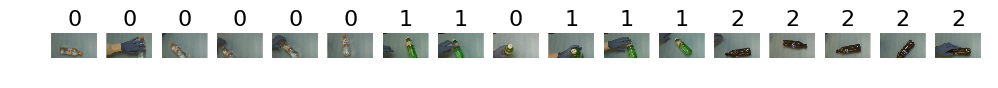

In [38]:
imgs = [cv2.imread(i) for i in subset]
preds = [np.argmax(eval_single_image(trained_model2, i, base_model['image_dims'])) for i in subset]
plots(imgs, titles = preds)
